In [1]:

import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Bidirectional, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:

df = pd.read_csv(r"C:\Users\RS10\Documents\Python\Master Inge\Machine learning\Projet\Standardize.csv")
df = df[df['x'] != 'x']
df[['x', 'y', 'z', 'time']] = df[['x', 'y', 'z', 'time']].astype(float)
df['gesture'] = df['gesture'].astype(int)

grouped = df.groupby(['user', 'gesture', 'sequence'])
sequences = defaultdict(list)
for (user, gesture, sequence), group in grouped:
    seq = group.sort_values(by='time')[['x', 'y', 'z', 'time']].to_numpy()
    sequences[(user, gesture)].append(seq)


In [3]:

def preprocess_sequences(sequence_list, max_len=None, scaler=None, fit_scaler=True):
    X, y = [], []
    for gesture_id, seqs in sequence_list:
        for seq in seqs:
            original_len = seq.shape[0]
            original_indices = np.linspace(0, 1, original_len)
            target_indices = np.linspace(0, 1, max_len)
            interpolated_features = [
                np.interp(target_indices, original_indices, seq[:, col].astype(float))
                for col in range(4)
            ]
            interpolated_seq = np.stack(interpolated_features, axis=1)
            X.append(interpolated_seq)
            y.append(gesture_id)
    X = np.array(X)
    if fit_scaler:
        scaler = StandardScaler()
        X = scaler.fit_transform(X.reshape(-1, 4)).reshape(X.shape)
    else:
        X = scaler.transform(X.reshape(-1, 4)).reshape(X.shape)
    y = to_categorical(np.array(y), num_classes=10)
    return X, y, scaler


In [4]:
def build_full_lstm(input_shape):
    inputs = Input(shape=input_shape)
    x = Masking(mask_value=0.)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.1)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu', name="embedding")(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def extract_embedding_model(full_model):
    return Model(inputs=full_model.input, outputs=full_model.get_layer("embedding").output)


In [5]:

def evaluate_lstm_knn(sequences, k=1):
    users = sorted(set(u for u, _ in sequences))
    accuracies = []
    all_y_true, all_y_pred = [], []

    for test_user in tqdm(users, desc="LSTM + k-NN Evaluation"):
        train_seqs = [((g), s) for (u, g), s in sequences.items() if u != test_user]
        test_seqs  = [((g), s) for (u, g), s in sequences.items() if u == test_user]

        max_len = max(seq.shape[0] for _, seqs in train_seqs + test_seqs for seq in seqs)
        X_train, y_train, scaler = preprocess_sequences(train_seqs, max_len=max_len, fit_scaler=True)
        X_test, y_test, _ = preprocess_sequences(test_seqs, max_len=max_len, scaler=scaler, fit_scaler=False)

        model = build_full_lstm((max_len, 4))
        model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=16, verbose=0, callbacks=[early_stopping])
        embedding_model = extract_embedding_model(model)
        X_train_embed = embedding_model.predict(X_train, verbose=0)
        X_test_embed = embedding_model.predict(X_test, verbose=0)

        y_train_labels = np.argmax(y_train, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_embed, y_train_labels)
        y_pred = knn.predict(X_test_embed)

        acc = accuracy_score(y_test_labels, y_pred)
        accuracies.append(acc)
        all_y_true.extend(y_test_labels)
        all_y_pred.extend(y_pred)

    print("LSTM + k-NN Accuracy: {:.2f}% ± {:.2f}".format(100 * np.mean(accuracies), 100 * np.std(accuracies)))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=sorted(set(all_y_true)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title("Confusion Matrix (LSTM + k-NN)")
    plt.show()
    return accuracies


LSTM + k-NN Evaluation: 100%|██████████| 10/10 [14:33<00:00, 87.36s/it]


LSTM + k-NN Accuracy: 61.30% ± 18.32


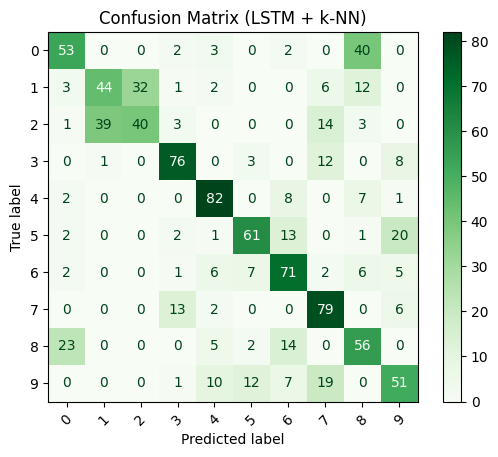

[0.51, 0.37, 0.89, 0.51, 0.64, 0.78, 0.56, 0.88, 0.65, 0.34]

In [9]:
evaluate_lstm_knn(sequences)

In [11]:
def evaluate_leave_one_sample_per_gesture_out_lstm(sequences, k=1):
    users = sorted(set(u for u, _ in sequences.keys()))
    accuracies = []
    all_y_true, all_y_pred = [], []

    for user in tqdm(users, desc="LSTM Leave-One-Sample-Per-Gesture-Out CV"):
        user_data = {k: v for k, v in sequences.items() if k[0] == user}

        # Ensure each gesture has at least 10 samples
        if not all(len(seq_list) >= 10 for (u, g), seq_list in user_data.items() if u == user):
            print(f"User {user} skipped due to insufficient gesture samples.")
            continue

        for i in range(10):  # 10 folds, one for each gesture sample
            train_data = []
            test_data = []

            for (u, gesture), seq_list in user_data.items():
                test_seq = seq_list[i]
                train_seqs = [seq for j, seq in enumerate(seq_list) if j != i]

                test_data.append((gesture, test_seq))
                train_data.extend([(gesture, seq) for seq in train_seqs])

            # Determine max length for padding/interpolation
            max_len = max(seq.shape[0] for _, seq in train_data + test_data)

            # Preprocess
            grouped_train = [(g, [s]) for g, s in train_data]
            grouped_test = [(g, [s]) for g, s in test_data]

            X_train, y_train, scaler = preprocess_sequences(grouped_train, max_len=max_len, fit_scaler=True)
            X_test, y_test, _ = preprocess_sequences(grouped_test, max_len=max_len, scaler=scaler, fit_scaler=False)

            # Build and train LSTM
            model = build_full_lstm((max_len, 4))
            model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=16, verbose=0)

            embedding_model = extract_embedding_model(model)
            X_train_embed = embedding_model.predict(X_train, verbose=0)
            X_test_embed = embedding_model.predict(X_test, verbose=0)

            y_train_labels = np.argmax(y_train, axis=1)
            y_test_labels = np.argmax(y_test, axis=1)

            # k-NN classification
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train_embed, y_train_labels)
            y_pred = knn.predict(X_test_embed)

            acc = accuracy_score(y_test_labels, y_pred)
            accuracies.append(acc)
            all_y_true.extend(y_test_labels)
            all_y_pred.extend(y_pred)

    if not all_y_true:
        print("No predictions made. Possibly due to insufficient data.")
        return accuracies

    print("LSTM Leave-One-Sample-Per-Gesture-Out Accuracy: {:.2f}% ± {:.2f}".format(
        100 * np.mean(accuracies), 100 * np.std(accuracies)))

    # Confusion Matrix
    labels = sorted(set(all_y_true + all_y_pred))
    cm = confusion_matrix(all_y_true, all_y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45, cmap="Oranges")
    plt.title("Confusion Matrix (LSTM Leave-One-Gesture-Sample-Out CV)")
    plt.show()

    return accuracies

In [ ]:
evaluate_leave_one_sample_per_gesture_out_lstm(sequences)

LSTM Leave-One-Sample-Per-Gesture-Out CV:   0%|          | 0/10 [00:00<?, ?it/s]